# Optymalizacja hiperparametrów

Zad.5. Użyj metody GridSearchCV wybierajac zakres hiperparametrów dla modelu Xgboost i SVM (iloczyn liczby wszystkich kombinacji w gridsearch nie powinien przekroczyć 25). Wykonaj to na zbiorze breast_cancer.csv używając funkcji prepare_dataset, replace (aby pozbyć się '?') oraz standard_scaler aby przeskalować dane (patrz skrypt Zespoły klasyfikatorów), jako odp zapisz Gini dla SVM i Gini dla Xgboost z najlepszymi paraemtrami zwróconymi przez GridSearchCV. Zwróć na czas wykonywania.

Wczytanie potrzebnych bibliotek

In [1]:
!git clone https://github.com/matzim95/ML-datasets


Cloning into 'ML-datasets'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 194 (delta 33), reused 124 (delta 24), pack-reused 60
Receiving objects: 100% (194/194), 35.45 MiB | 23.15 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [2]:
import pandas as pd

def load_dataset(filename, class_column, index_col=None):
    dataset = pd.read_csv(f'ML-datasets/{filename}.csv', index_col=index_col)
    dataset['class'] = dataset[class_column].astype('category').cat.codes
    classes = dataset.pop(class_column).unique()
    return dataset, classes

def prepare_dataset(dataset_name):
    params = {'iris': {'class_column': 'species', 'index_col': None},
              'wine': {'class_column': 'Class', 'index_col': None},
              'glass': {'class_column': 'Type', 'index_col': 'ID'},
              'breast_cancer': {'class_column': 'Class', 'index_col': 'Sample code number'}}
    dataset, classes = load_dataset(dataset_name,
                                    **params[dataset_name])
    y = dataset.pop('class')
    X = dataset
    return X, y, classes

In [3]:
X, y, classes = prepare_dataset('wine')

In [4]:
classes

array(['one', 'two', 'three'], dtype=object)

Bagging
---

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import Normalizer, StandardScaler


In [6]:
normalizer = Normalizer()
standarizer = StandardScaler()
preprocessor = standarizer

## Testy na zbiorach danych

In [7]:

def preprocess_data(X, preprocessor=None):
    if preprocessor is not None:
        preprocessor.fit(X)
        X_preprocessed = X.copy()
        X_preprocessed[:] = preprocessor.transform(X.values)
        X = X_preprocessed
    return X

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# average:
#   None - wyniki dla każdej klasy osobno
#   'binary' - dla wybranej w `pos_label` etykiety
#   'micro' - dla całkowitej liczby TP, FN, FP
#   'macro' - nieważona średnia dla każdej klasy
#   'weighted' - ważona średnia dla każdej klasy

def calculate_metrics(target, prediction, average='macro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall:    {metrics[2]}')
    print(f'  F1 score:  {metrics[3]}')
    print(f'  Mislabeled {metrics[4]} out of {metrics[5]}')
    print('\n')
    
def plot_confusion_matrix(confusion_matrix, classes, title=None,
                          title_appendix='',
                          cmap=plt.cm.Blues):
    # tytuł wykresu
    if title_appendix:
        title_appendix = f'({title_appendix})'
    if title is None:
        title = f'Confusion matrix {title_appendix}'
    
    fig, ax = plt.subplots()
    # rysuje CM (confusion matrix)
    img = ax.imshow(confusion_matrix, cmap=cmap)
    # dodaje pasek z boku
    ax.figure.colorbar(img, ax=ax)
    # dodatki do wykresu
    ax.set_xticks(np.arange(confusion_matrix.shape[1]))
    ax.set_xticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(np.arange(confusion_matrix.shape[0]))
    ax.set_yticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
    # etykiety
    fmt = '.2f' if confusion_matrix.dtype == 'float' else 'd'
    thresh = confusion_matrix.max() / 2
    for y, row in enumerate(confusion_matrix):
        for x, cell in enumerate(row):
            ax.text(x, y, format(cell, fmt),
                    ha='center', va='center',
                    color='white' if cell > thresh else 'black')
    fig.tight_layout()
    
    return ax

def normalize_confusion_matrix(confusion_matrix):
    return confusion_matrix.astype(
        'float') / confusion_matrix.sum(
        axis=1)[np.newaxis].T

In [9]:
X, y, classes = prepare_dataset('breast_cancer')
X = X.replace('?',np.NaN)
X['Bare Nuclei'] = X['Bare Nuclei'].fillna(X['Bare Nuclei'].median())
X = preprocess_data(X, standarizer)
X.describe()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
count,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02
mean,1.655011e-16,-2.801765e-16,-5.854481e-16,-1.477121e-16,-1.021199e-15,7.026648e-16,6.251556e-16,3.874662e-16,7.093356e-16
std,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00
min,-1.214667e+00,-6.999951e-01,-7.432990e-01,-6.332472e-01,-1.001495e+00,-6.869792e-01,-1.000471e+00,-6.118250e-01,-3.439118e-01
25%,-8.592662e-01,-6.999951e-01,-7.432990e-01,-6.332472e-01,-5.495614e-01,-6.869792e-01,-5.900668e-01,-6.118250e-01,-3.439118e-01
50%,-1.484649e-01,-6.999951e-01,-7.432990e-01,-6.332472e-01,-5.495614e-01,-6.869792e-01,-1.796621e-01,-6.118250e-01,-3.439118e-01
75%,5.623364e-01,6.117919e-01,6.035993e-01,4.181537e-01,3.543054e-01,4.181956e-01,6.411472e-01,3.713145e-01,-3.439118e-01
max,1.983939e+00,2.251526e+00,2.287222e+00,2.520955e+00,3.065906e+00,1.799664e+00,2.693171e+00,2.337594e+00,4.907421e+00


In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb 

import warnings
import sklearn

from sklearn.metrics import roc_auc_score, accuracy_score # wczytanie metryk sukcesu
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = 250
seed = 2019
warnings.simplefilter("ignore")

print('numpy ' + str(np.__version__))
print('pandas ' + str(pd.__version__))
print('seaborn ' + str(pd.__version__))
print('xgboost ' + str(pd.__version__))
print('sklearn ' + str(sklearn.__version__))

numpy 1.21.6
pandas 1.3.5
seaborn 1.3.5
xgboost 1.3.5
sklearn 1.0.2


Wczytanie pliku z danymi. W poniższym przykładzie użyłem danych z konkursu Kaggle: <br> 
https://www.kaggle.com/c/santander-customer-transaction-prediction/data

#### Funkcje pomocnicze

In [11]:
def get_feats(df): #dzieki temu nie będę brał niepotrzebnych kolumn do modelowania
    feats = [f for f in df.columns if f not in ['ID_code','target']]
    return feats

def get_X(df): #do pobierania macierzy X czyli cech które będę starał się opisywac modelem
    return df[ get_feats(df) ].values

def get_y(df, target_var='target'): #wektor y - informacja o predycji. w przypadku przykładowych danych to ":target"
    return df[target_var].values

#### Podział zbioru do nauki modelu, testowy i walidacyjny

In [12]:
#X, y = get_X(df), get_y(df) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2019)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=2019)

print('TRAIN:',X_train.shape, y_train.shape)
print('TEST:',X_test.shape, y_test.shape)
print('VALIDATION:',X_val.shape, y_val.shape)

TRAIN: (419, 9) (419,)
TEST: (140, 9) (140,)
VALIDATION: (140, 9) (140,)


#### Walidacja modelu
Zdefiniujmy sobie funkcję dzięki którym od razu sprawdzimy jak model działa.<br>
W tym przypadku przyglądnijmy się metryce GINI.

In [13]:
def create_measures(y,y_pred): 
    score_test = roc_auc_score(y, y_pred)
    Gini_index = 2*score_test - 1
    
    d = {'AUC': [round(score_test,4)], 'GINI': [round(Gini_index,4)]}
    d = pd.DataFrame.from_dict(d)
    return d

def calculating_metrics(X_train, X_val, X_oot, y_train, y_val, y_oot):
    train = create_measures(y_train,model.predict_proba(X_train)[:, 1])
    test = create_measures(y_test,model.predict_proba(X_test)[:, 1])
    val = create_measures(y_val,model.predict_proba(X_val)[:, 1]) 

    measures =  pd.concat([train,test,val]).set_index([pd.Index(['TRAIN', 'TEST', 'VAL'])]) 
    
    return measures

#### Budowa modelu XGB na domyślnych parametrach

In [14]:
model = xgb.XGBClassifier(tree_method='gpu_hist')
model.fit(X_train, y_train)  
measures = calculating_metrics(X_train, X_test, X_val, y_train, y_test, y_val)
measures

,AUC,GINI
TRAIN,0.9999,0.9999
TEST,0.9945,0.9891
VAL,0.9945,0.9891


### Grid Search - xgb

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
grid_param = {  
    'n_estimators': [50, 60],
    'max_depth': [5],
    'learning_rate': [ 0.1, 0.25],
    'subsample': [0.75, 1.00], 
    'tree_method': ['gpu_hist']    
}

In [17]:
print(4*4*4*2)

128


In [18]:
grid_search = GridSearchCV(estimator=model,  
                     param_grid=grid_param,
                     scoring='roc_auc')

In [19]:
grid_search.fit(X_train, y_train) 

best_parameters = grid_search.best_params_  
print(best_parameters) 

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.75, 'tree_method': 'gpu_hist'}


In [20]:
model = xgb.XGBClassifier(**best_parameters)
model.fit(X_train, y_train)  
measures = calculating_metrics(X_train, X_test, X_val, y_train, y_test, y_val)
measures

,AUC,GINI
TRAIN,0.9998,0.9997
TEST,0.9907,0.9815
VAL,0.9907,0.9815


In [21]:
GS_results = pd.DataFrame(grid_search.cv_results_)
GS_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.217590,0.002413,0.002099,0.000307,0.1,5,50,0.75,gpu_hist,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.989796,0.988520,0.995536,0.984056,0.986364,0.988854,0.003870,1
1,0.220884,0.000983,0.002139,0.000297,0.1,5,50,1.0,gpu_hist,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.987883,0.987245,0.988520,0.982143,0.980519,0.985262,0.003275,8
2,0.255659,0.003487,0.001885,0.000070,0.1,5,60,0.75,gpu_hist,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.989796,0.988520,0.993622,0.984694,0.987013,0.988729,0.002978,2
3,0.256888,0.001723,0.001902,0.000102,0.1,5,60,1.0,gpu_hist,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.987245,0.987245,0.987883,0.981505,0.983766,0.985529,0.002479,6
4,0.213123,0.001828,0.001891,0.000096,0.25,5,50,0.75,gpu_hist,"{'learning_rate': 0.25, 'max_depth': 5, 'n_est...",0.986607,0.987883,0.991071,0.985332,0.982468,0.986672,0.002839,4


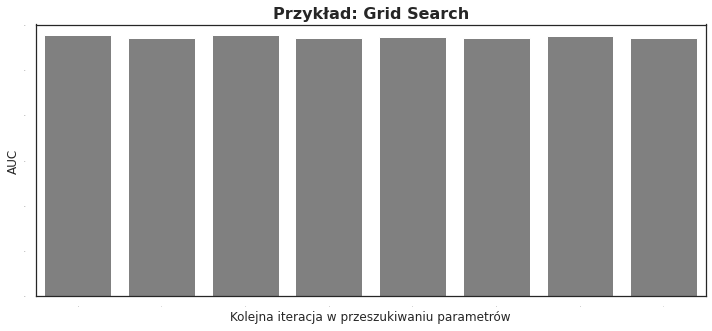

In [22]:
sns.set(style="white", rc={'figure.figsize':(12,5), 'axes.grid': False}, font_scale=0)
ax = sns.barplot(x=GS_results.index, y='mean_test_score', data=GS_results, color="gray")

ax.set_title("Przykład: Grid Search",fontsize=16,weight='bold')
ax.set_xlabel("Kolejna iteracja w przeszukiwaniu parametrów",fontsize=12)
ax.set_ylabel("AUC", fontsize=12)
ax.set(ylim=(0.7, 1.0));

### Grid Search - svm

In [23]:
def create_measures(y,y_pred): 
    score_test = roc_auc_score(y, y_pred)
    Gini_index = 2*score_test - 1
    
    d = {'AUC': [round(score_test,4)], 'GINI': [round(Gini_index,4)]}
    d = pd.DataFrame.from_dict(d)
    return d

def calculating_metrics(X_train, X_val, X_oot, y_train, y_val, y_oot):
    train = create_measures(y_train,model.predict_proba(X_train)[:, 1])
    test = create_measures(y_test,model.predict_proba(X_test)[:, 1])
    val = create_measures(y_val,model.predict_proba(X_val)[:, 1]) 

    measures =  pd.concat([train,test,val]).set_index([pd.Index(['TRAIN', 'TEST', 'VAL'])]) 
    
    return measures

In [24]:
model = SVC(probability=True)
model.fit(X_train, y_train)  
measures = calculating_metrics(X_train, X_test, X_val, y_train, y_test, y_val)
measures

,AUC,GINI
TRAIN,0.9957,0.9914
TEST,0.9861,0.9722
VAL,0.9861,0.9722


In [25]:
?SVC

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
grid_param = {  
    'kernel': ['rbf', 'poly'],
    'C': [0.1,1,10,100],
    'gamma': ['scale', 'auto'],    
}

In [28]:
print(4*4*4*2)

128


In [29]:
grid_search = GridSearchCV(estimator=model,  
                     param_grid=grid_param,
                     scoring='roc_auc')

In [30]:
grid_search.fit(X_train, y_train) 

best_parameters = grid_search.best_params_  
print(best_parameters) 

{'C': 10, 'gamma': 'auto', 'kernel': 'poly'}


In [31]:
model = SVC(**best_parameters, probability = True)
model.fit(X_train, y_train)  
measures = calculating_metrics(X_train, X_test, X_val, y_train, y_test, y_val)
measures

,AUC,GINI
TRAIN,0.9992,0.9984
TEST,0.9952,0.9903
VAL,0.9952,0.9903


In [32]:
GS_results = pd.DataFrame(grid_search.cv_results_)
GS_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013391,0.002399,0.002364,0.000073,0.1,scale,rbf,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",0.992347,0.990434,0.994260,0.979592,0.991558,0.989638,0.005176,12
1,0.007516,0.000204,0.002114,0.000079,0.1,scale,poly,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}",0.994260,0.989796,0.994898,0.992985,0.994156,0.993219,0.001820,5
2,0.011543,0.000627,0.002570,0.000201,0.1,auto,rbf,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}",0.992347,0.990434,0.994260,0.980230,0.992208,0.989896,0.004982,11
3,0.007553,0.000213,0.002179,0.000103,0.1,auto,poly,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}",0.992347,0.989796,0.994898,0.992347,0.993506,0.992579,0.001679,6
4,0.008926,0.000404,0.002443,0.000625,1,scale,rbf,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.996811,0.989158,0.994260,0.982143,0.995455,0.991565,0.005376,7


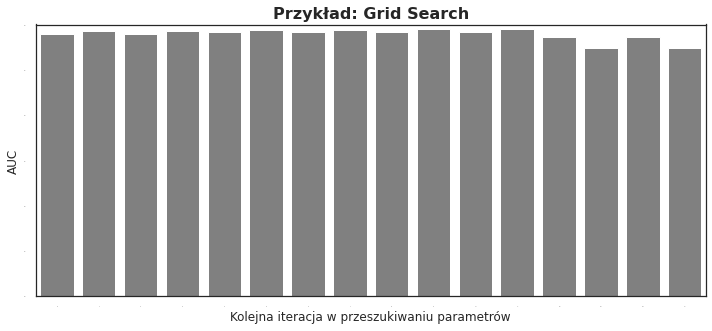

In [33]:
sns.set(style="white", rc={'figure.figsize':(12,5), 'axes.grid': False}, font_scale=0)
ax = sns.barplot(x=GS_results.index, y='mean_test_score', data=GS_results, color="gray")

ax.set_title("Przykład: Grid Search",fontsize=16,weight='bold')
ax.set_xlabel("Kolejna iteracja w przeszukiwaniu parametrów",fontsize=12)
ax.set_ylabel("AUC", fontsize=12)
ax.set(ylim=(0.7, 1.0));

### Random Search

In [34]:
from sklearn.model_selection import RandomizedSearchCV

In [35]:
random_param = {
    'max_depth': range(1,9),
    'learning_rate': np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000),
    'n_estimators': range(100, 1000, 50),
    'gamma': np.linspace(0, 1, 10),
    'min_child_weight': range(1,100,5),
    'subsample': np.linspace(0.5, 1, 101),
    'colsample_bytree': np.linspace(0.5, 1, 101),
    'colsample_bylevel': np.linspace(0.5, 1, 101),
    'reg_alpha': np.linspace(0, 2),
    'reg_lambda': np.linspace(0, 2),
    'tree_method': ['gpu_hist']
}

In [36]:
random_param1 = {
    'n_estimators': [50, 60],
    'max_depth': [5],
    'learning_rate': [ 0.1, 0.25],
    'subsample': [0.75, 1.00], 
    'tree_method': ['gpu_hist'] 
}

In [37]:
model = xgb.XGBClassifier()

random_search = RandomizedSearchCV(estimator=model
                                 , param_distributions=random_param1
                                 , scoring='roc_auc' )

In [38]:
random_search.fit(X=X_train, y=y_train)

best_parameters = random_search.best_params_  
print(best_parameters) 

{'tree_method': 'gpu_hist', 'subsample': 0.75, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}


In [39]:
model = xgb.XGBClassifier(**best_parameters)
model.fit(X_train, y_train)  
measures = calculating_metrics(X_train, X_test, X_val, y_train, y_test, y_val)
measures

,AUC,GINI
TRAIN,0.9998,0.9997
TEST,0.9907,0.9815
VAL,0.9907,0.9815


In [40]:
RS_results = pd.DataFrame(random_search.cv_results_)
RS_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree_method,param_subsample,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.223930,0.008720,0.002698,0.001309,gpu_hist,0.75,50,5,0.1,"{'tree_method': 'gpu_hist', 'subsample': 0.75,...",0.989796,0.988520,0.995536,0.984056,0.986364,0.988854,0.003870,1
1,0.222272,0.002924,0.002046,0.000133,gpu_hist,1.0,50,5,0.1,"{'tree_method': 'gpu_hist', 'subsample': 1.0, ...",0.987883,0.987245,0.988520,0.982143,0.980519,0.985262,0.003275,8
2,0.255543,0.001422,0.002198,0.000174,gpu_hist,0.75,60,5,0.1,"{'tree_method': 'gpu_hist', 'subsample': 0.75,...",0.989796,0.988520,0.993622,0.984694,0.987013,0.988729,0.002978,2
3,0.257043,0.000737,0.002153,0.000178,gpu_hist,1.0,60,5,0.1,"{'tree_method': 'gpu_hist', 'subsample': 1.0, ...",0.987245,0.987245,0.987883,0.981505,0.983766,0.985529,0.002479,6
4,0.213266,0.001773,0.002121,0.000241,gpu_hist,0.75,50,5,0.25,"{'tree_method': 'gpu_hist', 'subsample': 0.75,...",0.986607,0.987883,0.991071,0.985332,0.982468,0.986672,0.002839,4


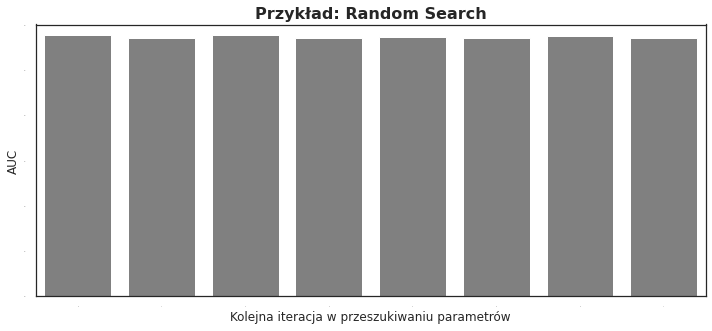

In [41]:
sns.set(style="white", rc={'figure.figsize':(12,5), 'axes.grid': False}, font_scale=0)
ax = sns.barplot(x=RS_results.index, y='mean_test_score', data=RS_results, color="gray")

ax.set_title("Przykład: Random Search",fontsize=16,weight='bold')
ax.set_xlabel("Kolejna iteracja w przeszukiwaniu parametrów",fontsize=12)
ax.set_ylabel("AUC", fontsize=12)
ax.set(ylim=(0.7, 1.0));

### Baysian Search

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, partial # procedury do optymalizacji hiperparametrów

In [ ]:
# parametr mówiący ile iteracji najpierw losujemy zanim zaczniemy optymalizować parametry
n_startup_jobs = 4*4*2*1 # liczba całkowita > 0

# parametr ile łącznie robimy iteracji 
max_evals = 4*4*4*2 # liczba całkowita > n_startup_jobs

BS_results = []

In [ ]:
# Określenie zakresu do przeszukiwania dla hiperparametrów.
# Można modyfikować dowolnie według uznania
space ={
    'learning_rate': hp.uniform ('x_learning_rate', 0.01, 0.5),
    'max_depth': hp.quniform ('x_max_depth', 1, 9, 1),
    'n_estimators': hp.quniform ('x_n_estimators', 100, 1000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 0, 100, 1),
    'gamma': hp.loguniform ('x_gamma', 0.0, 2.0),
    'subsample': hp.uniform ('x_subsample', 0.5, 1.0),    
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.5, 1.0),
    'colsample_bylevel': hp.uniform ('x_colsample_bylevel', 0.5, 1.0),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.loguniform ('x_reg_lambda', 0.0, 2.0),
}

In [ ]:
def objective(space):
    xgb_params = {
        # ogólne
        'learning_rate': space['learning_rate'],
        'max_depth': int(space['max_depth']),
        'n_estimators': int(space['n_estimators']),
        'min_child_weight': int(space['min_child_weight']),
        'gamma': space['gamma'],
        'seed': 2019,
        # do walki z overfiting
        'subsample': space['subsample'],
        'colsample_bytree': space['colsample_bytree'],
        'colsample_bylevel': space['colsample_bylevel'],
        # regularyzacja
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        # pozostałe
        'metric': 'auc',  
        'eval_metric': 'auc', 
        'tree_method': 'gpu_hist'
    }

    model = xgb.XGBClassifier(**xgb_params)
    %time model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    
    score = - roc_auc_score(y_test, y_pred)
    
    BS_results.append([roc_auc_score(y_test, y_pred), xgb_params])
    
    print("SCORE: {0}".format(roc_auc_score(y_test, y_pred)))
    
    return{'loss':score, 'status': STATUS_OK }

<div class="alert alert-block alert-danger">
UWAGA! Hyperopt szuka minimum. Zatem jak Twoja metryka im wyższa tym lepiej (jak AUC) wówczas należy przemnożyć ją przez -1 jak w powyższym przykładzie:  score = - roc_auc_score(y_test, y_pred).<br>
</div>

In [ ]:
trials = Trials()
best_params = fmin(fn=objective,
                   space=space,
                   algo=partial(tpe.suggest, n_startup_jobs=n_startup_jobs),
                   max_evals=max_evals,
                   trials=trials)

print("The best params: ", best_params)

In [ ]:
import pandas as pd
BS_results = pd.DataFrame(BS_results)
BS_results.columns = ['score','params']
BS_results.head()

In [ ]:
sns.set(style="white", rc={'figure.figsize':(12,5), 'axes.grid': False}, font_scale=0)
ax = sns.barplot(x=BS_results.index, y='score', data=BS_results, color="gray")

ax.set_title("Przykład: Baysian Search",fontsize=16,weight='bold')
ax.set_xlabel("Kolejna iteracja w przeszukiwaniu parametrów",fontsize=12)
ax.set_ylabel("AUC", fontsize=12)
ax.set(ylim=(0.7, 1.0));

In [ ]:
best_params

In [ ]:
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)  
measures = calculating_metrics(X_train, X_test, X_val, y_train, y_test, y_val)
measures

In [ ]:
GS_results.to_csv('GS_results.csv')
RS_results.to_csv('RS_results.csv')
BS_results.to_csv('BS_results.csv')